# HackerEarth Machine Learning Challenge
## Predict the employee burn out rate

**ABOUT CHALLENGE** <br>
*To win in the marketplace, you must first win in the workplace.*
~ Doug Conant

And rightly so! Happy and healthy employees are indisputably more productive at work, and in turn, help the business flourish profoundly.

However, since working from home has become the new strange normal, over 69% of employees have been showing burnout symptoms globally (source: Monster poll). This rate of burnout is indeed alarming and the likes of Google and Cisco (even HackerEarth!) are taking steps that ensure wellness and reduce burnout among employees.

On the occasion of World Mental Health Day this October 10th, your organization has stepped in to help its employees plan their weekly calendars appropriately so as to prevent burning out. Your task, as a Machine Learning engineer, is to build a Machine Learning model that predicts burnout rate based on numerous factors such as WFH setup, resources, mental fatigue score, and the like.

***
**Participant:** Mert Gül<br>
Hackathon Link: [HackerEarth](https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-predict-burnout-rate/)<br>
More information on the dataset: [Kaggle](https://www.kaggle.com/blurredmachine/are-your-employees-burning-out)
***

# 1\. Introduction

## 1.1 Imports & Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 2\. Preprocessing

## 2.1 Examine The Dataset

In [3]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [5]:
# number of unique values per variable
train.nunique()

Employee ID             22750
Date of Joining           366
Gender                      2
Company Type                2
WFH Setup Available         2
Designation                 6
Resource Allocation        10
Mental Fatigue Score      101
Burn Rate                 101
dtype: int64

In [6]:
# number of empty values
train.isnull().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [7]:
# number of empty values (test)
test.isnull().sum()

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

## 2.2 Processing The Variables

### 2.2.1 One-Hot Encoding

It would be useful to convert these columns;
* Gender
* Company Type
* WFH Setup Available<br>

to binary values by **one-hot encoding**.

#### 2.2.1.1 Train Set

In [8]:
is_male = pd.get_dummies(train.Gender, drop_first=True)
is_service = pd.get_dummies(train["Company Type"], drop_first=True)
wfh_available = pd.get_dummies(train["WFH Setup Available"], drop_first=True)

In [9]:
for loc, column in enumerate(["is_male", "is_service", "wfh_available"], start=2):
    train.insert(loc=loc, column=column, value=eval(column))

train.drop(columns=["Gender", "Company Type", "WFH Setup Available"], axis=1, inplace=True)

In [10]:
train.head()

,Employee ID,Date of Joining,is_male,is_service,wfh_available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,0,1,0,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,1,1,1,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,0,0,1,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,1,1,1,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,0,1,0,3.0,7.0,6.9,0.52


#### 2.2.1.2 Test Set

In [11]:
is_male = pd.get_dummies(test.Gender, drop_first=True)
is_service = pd.get_dummies(test["Company Type"], drop_first=True)
wfh_available = pd.get_dummies(test["WFH Setup Available"], drop_first=True)

for loc, column in enumerate(["is_male", "is_service", "wfh_available"], start=2):
    test.insert(loc=loc, column=column, value=eval(column))

test.drop(columns=["Gender", "Company Type", "WFH Setup Available"], 
          axis=1, 
          inplace=True)

### 2.2.2 The Column: "Date of Joining"
All the employees in the dataset seem to join in 2008. Thus, omiting the year and converting the dates to integers (just to days) ***might*** help us a bit along the way. Here what we are going to do is:<br>
* **Remove the year**
* **Convert month + day to only days**
    * *Example-1:* join date of 01-20 (Jan 20th) will have $1*31 + 20 = 51$ days
    * *Example-2:* join date of 12-30 (Dec 30th) will have $2*31 + 30 = 402$ days
* **Inverse the sorting** because the smaller the integers are, the more experienced employee will be.
    * *Example:* So, the newest guy will have the maximum, the oldest will have the minimum days, right?
    * To inverse the situation, a simple calculation will be performed:
        * At the end, the oldest guy will have $|newGuysDays - oldGuysDays|$ in total w.r.t the new guy.
        * And the newest guy will have 0 days.
* Finally, **Normalize the numbers** to work with them better.<br>

**Note:** All these process would be in vain because it might not affect the model at all. We will see :)

In [12]:
%%time
month_dict = {"01":31, "02":29, "03":31, 
              "04":30, "05":31, "06":30, 
              "07":31, "08":31, "09":30, 
              "10":31, "11":30, "12":31}

for dataset in (train, test):
    for i in range(len(dataset)):
        x = dataset["Date of Joining"][i].split("-")    # sample output: ['2008', '09', '30']
        x = eval(f"{int(x[1])} * {month_dict[x[1]]} + {int(x[2])}")    # sample output: 300
        dataset.loc[i, "Date of Joining"] = x

    dataset["Date of Joining"] = dataset["Date of Joining"].astype("float32")
    dataset["Date of Joining"] = abs(dataset["Date of Joining"] - dataset["Date of Joining"].max())
    dataset["Date of Joining"] /= dataset["Date of Joining"].max()

Wall time: 21.1 s


### 2.2.3 NaN Values

In [13]:
# there are NaNs in the most critical variables
# let's dive into the details
resource_nan = train["Resource Allocation"].isna()
mental_nan = train["Mental Fatigue Score"].isna()
burnrate_nan = train["Burn Rate"].isna()

# No "Burn Rate" & "Mental Fatigue Score" values
train[(burnrate_nan) & (mental_nan)]

,Employee ID,Date of Joining,is_male,is_service,wfh_available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
45,fffe31003500330034003700,0.404313,1,1,1,2.0,3.0,NaN,NaN
47,fffe3500320032003000,0.765499,0,0,1,3.0,6.0,NaN,NaN
122,fffe31003400350030003200,0.584906,0,0,0,3.0,5.0,NaN,NaN
127,fffe3900340036003300,0.921833,1,1,0,3.0,5.0,NaN,NaN
135,fffe32003200360039003000,0.641509,0,1,1,1.0,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
21507,fffe3300370033003600,0.911051,1,1,0,2.0,4.0,NaN,NaN
21701,fffe3400360038003300,0.126685,1,0,1,2.0,4.0,NaN,NaN
21888,fffe31003900360035003200,0.792453,1,1,0,3.0,6.0,NaN,NaN
21937,fffe3700350034003500,0.318059,1,1,0,3.0,6.0,NaN,NaN


We can roughly predict the **Burn Rate** by **Mental Fatigue Score** (and vice-versa) but the absence of these values gives us a hard time and trying to predict the **Burn Rate** would be an example of overestimation. Thus we had better remove these double-NaN values to make things simpler.

In [14]:
# Index values of NaN values of "Burn Rate" & "Mental Fatigue Score"
double_nan_indices = train[(burnrate_nan) & (mental_nan)].index

train.drop(index=double_nan_indices, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)
del double_nan_indices, is_male, is_service, wfh_available

In [15]:
# okay, what else?
train.isna().sum()

Employee ID                0
Date of Joining            0
is_male                    0
is_service                 0
wfh_available              0
Designation                0
Resource Allocation     1366
Mental Fatigue Score    1945
Burn Rate                952
dtype: int64

Before we move on, it would be a wise practice to check the correlations of the variables to form a solid idea on what to do with the NaN values.

In [16]:
train_corr = train.corr()

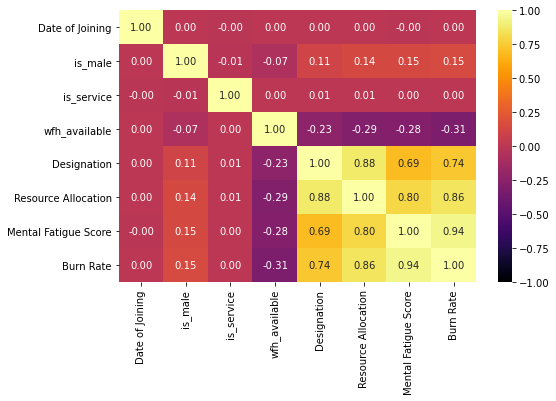

In [17]:
plt.figure(figsize=(8,5))
ax = sns.heatmap(data=train_corr, 
                 annot=True, 
                 fmt=".2f", 
                 vmin=-1, 
                 vmax=1, 
                 cmap="inferno")
plt.yticks(rotation=0)
plt.show()

In [18]:
# We have very high correlation between some of the variables.
# Let's focus on "Mental Fatigue Score" and "Burn Rate"
sns.set(style="whitegrid")

title_font = {"family":"arial", 
              "weight":"bold", 
              "color":"darkgreen", 
              "size":16}

axis_font = {"family":"serif", 
             "weight":"normal", 
             "color":"darkgreen", 
             "size":14}

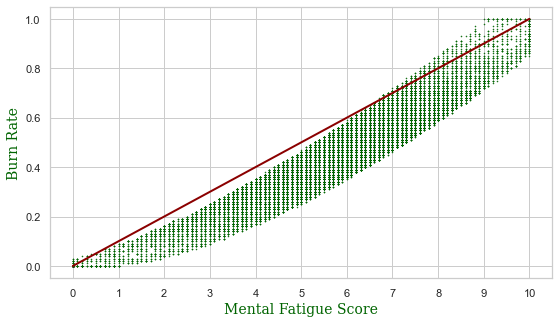

In [19]:
plt.figure(figsize=(9, 5))
plt.scatter("Mental Fatigue Score", "Burn Rate", data=train, s=0.3, c="darkgreen")
plt.plot([0,10], [0, 1], linewidth=2, c="darkred")
plt.xlabel("Mental Fatigue Score", fontdict=axis_font)
plt.ylabel("Burn Rate", fontdict=axis_font)
plt.xticks(range(0,11))
plt.show()

The correlation is almost linear.<br>We may fill the gaps by using this high correlation. "Interpolation" could be our savior. 

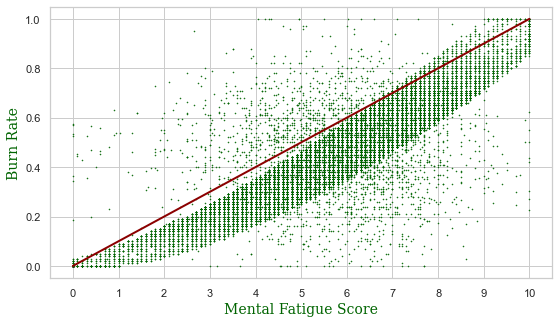

In [20]:
# to keep things safe, let's play on a copy of our train dataset
train_copy = pd.DataFrame()
for i in train.columns[-3:]:
    fill_with = train[i].interpolate(method="linear")
    train_copy[i] = train[i].fillna(fill_with, inplace=False)

plt.figure(figsize=(9, 5))
plt.scatter("Mental Fatigue Score", "Burn Rate", data=train_copy, s=0.3, c="darkgreen")
plt.plot([0,10], [0, 1], linewidth=2, c="darkred")
plt.xlabel("Mental Fatigue Score", fontdict=axis_font)
plt.ylabel("Burn Rate", fontdict=axis_font)
plt.xticks(range(0,11))
plt.show()
del train_copy

Random interpolation over the data made the dataset unnecessarily noisy. That why we should consider the correlations between the variables.<br>The things we are going to do are:<br>
* Create a copy of the dataset with *NaN-free* values on "Mental Fatigue Score" & "Burn Rate" variables
    * Because the interpolation will calculate the relationship in-between
* Bake the interpolation function, i.e $y = f(x)$
* Predict the NaN values by the function and replace them with the new values

...but first, let's look at the original values for the last time:

In [21]:
describe_original = train.describe()
describe_original

,Date of Joining,is_male,is_service,wfh_available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22578.000000,22578.000000,22578.000000,22578.000000,22578.000000,21212.000000,20633.000000,21626.000000
mean,0.507425,0.476482,0.652228,0.540305,2.178935,4.481001,5.728188,0.452005
std,0.286254,0.499458,0.476274,0.498384,1.134938,2.046963,1.920839,0.198226
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.277628,0.000000,0.000000,0.000000,1.000000,3.000000,4.600000,0.310000
50%,0.495957,0.000000,1.000000,1.000000,2.000000,4.000000,5.900000,0.450000
75%,0.754717,1.000000,1.000000,1.000000,3.000000,6.000000,7.100000,0.590000
max,1.000000,1.000000,1.000000,1.000000,5.000000,10.000000,10.000000,1.000000


In [22]:
from scipy import interpolate

In [23]:
# Let's create the copy of our dataset and
# make sure that there are no NaN values in
# "Mental Fatigue Score" & "Burn Rate" variables

train_copy = train.copy(deep=True)

not_na1 = train_copy["Mental Fatigue Score"].notna()
not_na2 = train_copy["Burn Rate"].notna()

train_copy = train_copy[(not_na1) & (not_na2)]
del not_na2, not_na1

In [24]:
# function to find the burn rate
fn_burn = interpolate.interp1d(x=train_copy["Mental Fatigue Score"], 
                               y=train_copy["Burn Rate"], 
                               kind="linear", 
                               fill_value=None)
# function to find the mental fatigue score
fn_mental = interpolate.interp1d(y=train_copy["Mental Fatigue Score"], 
                                 x=train_copy["Burn Rate"], 
                                 kind="linear", 
                                 fill_value=None)
del train_copy

In [25]:
# get rid of these NaNs
for i in train[train["Burn Rate"].isna()].index:
    train.loc[i, "Burn Rate"] = fn_burn(train.loc[i, "Mental Fatigue Score"])
    
for i in train[train["Mental Fatigue Score"].isna()].index:
    train.loc[i, "Mental Fatigue Score"] = fn_mental(train.loc[i, "Burn Rate"])

In [26]:
# well, what now?
train.isna().sum()

Employee ID                0
Date of Joining            0
is_male                    0
is_service                 0
wfh_available              0
Designation                0
Resource Allocation     1366
Mental Fatigue Score       0
Burn Rate                  0
dtype: int64

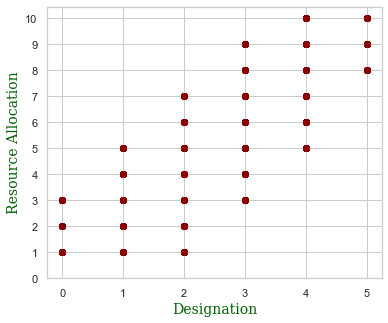

In [27]:
# remember that "Resource Allocation" is also highly correlated with Designation.
plt.figure(figsize=(6, 5))
plt.scatter("Designation", "Resource Allocation", data=train, c="darkred")
plt.xlabel("Designation", fontdict=axis_font)
plt.ylabel("Resource Allocation", fontdict=axis_font)
plt.yticks(range(0,11))
plt.show()

In [28]:
# We will get the mean of each "Designation" value and replace the NaN with them 
# Here, an example: 
temp_value = train["Resource Allocation"][train["Designation"]==1].mean()

print(f"The mean value of Resource Allocation where \
Designation == 1 is: {temp_value:.2f}")
del temp_value

The mean value of Resource Allocation where Designation == 1 is: 2.58


In [29]:
for i in range(6):    # 0 to 5, Designation values
    mean_value = train["Resource Allocation"][train["Designation"]==i].mean()
    
    # condition: "Designation" == i AND "Resource Allocation" is NaN
    condition = (train["Designation"]==i) & (train["Resource Allocation"].isna())
    
    # all NaN values are converted to mean values:
    train.loc[condition, "Resource Allocation"] = mean_value

In [30]:
# ...and it's gone!
train.isna().sum()

Employee ID             0
Date of Joining         0
is_male                 0
is_service              0
wfh_available           0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

As can be seen below, standard deviations are almost the same. Yay!

In [31]:
describe_botox = train.describe()

display(describe_original.iloc[:3, -3:])
display(describe_botox.iloc[:3, -3:])

,Resource Allocation,Mental Fatigue Score,Burn Rate
count,21212.000000,20633.000000,21626.000000
mean,4.481001,5.728188,0.452005
std,2.046963,1.920839,0.198226


,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22578.000000,22578.000000,22578.000000
mean,4.480784,5.718075,0.452212
std,2.031909,1.924218,0.198125


***

In [32]:
"""profile = ProfileReport(train, title="Profiling Report", explorative=True)
# profile.to_file("./burning_out_report.html")
profile.to_notebook_iframe()
# profile.to_widgets()"""

'profile = ProfileReport(train, title="Profiling Report", explorative=True)\n# profile.to_file("./burning_out_report.html")\nprofile.to_notebook_iframe()\n# profile.to_widgets()'